# Compute metrics for different runs and plot them
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.3.0

## Python stuff

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from build_data import build_hurricane_data
import model_diagnostics
import prediction
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "03 June 2022"

EXP_NAME_LIST = (
                 "intensity202_AL48",    #SHASH      
                 "intensity522_AL48",    #BNN
                 "intensity523_AL48",    #BNN-SHASH
                 "intensity521_AL48",    #MC-Dropout        
    
                 "intensity302_EPCP48",    #SHASH      
                 "intensity532_EPCP48",    #BNN
                 "intensity533_EPCP48",    #BNN-SHASH
                 "intensity531_EPCP48",    #MC-Dropout        
                 )

APPEND_NAME = ''#'_paper'

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "saved_metrics/"
FIGURE_PATH = "figures/paper_figures/"
PREDICTION_PATH = "saved_predictions/"

## Code for plots

In [3]:
FS = 16

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Get the dataframe

In [4]:
df_metrics = pd.DataFrame()

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)

    # set testing data
    if settings["test_condition"] == "leave-one-out":
        TESTING_YEARS_LIST = np.arange(2013,2022)
    elif settings["test_condition"] == "years":
        TESTING_YEARS_LIST = (np.copy(settings["years_test"]))
    else:
        raise NotImplementError('no such testing condition')
        
        
    for testing_years in TESTING_YEARS_LIST:        
        # set testing year
        settings["years_test"] = (testing_years,)
    
    
        for rng_seed in settings["rng_seed_list"]:
            settings['rng_seed'] = rng_seed
            NETWORK_SEED_LIST = [settings["rng_seed"]]
            network_seed = NETWORK_SEED_LIST[0]
    
            model_name = (
                exp_name + "_" + 
                str(testing_years) + '_' +
                settings["uncertainty_type"] + '_' + 
                f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )

            # load the metric filename
            metric_filename = METRIC_PATH + model_name + '_metrics.pickle'  
            if os.path.exists(metric_filename)==False:
                print(metric_filename + ' DOES NOT exist. Skipping...')
                continue

            # pprint.pprint(model_name)
            df = pd.read_pickle(metric_filename)
            # df['basin_lead'] = exp_name[exp_name.rfind('_')+1:]

            df_metrics = pd.concat([df_metrics,df])
# get best validation results            
idx = df_metrics.groupby(['exp_name', 'testing_years'], sort=False)['median_error_reduction_val'].transform(max) == df_metrics['median_error_reduction_val']
df_metrics_bestval = df_metrics[idx]

BEST_VAL_ONLY = True
if BEST_VAL_ONLY:
    print("**plotting only the best seed for validation error reductions**")
    df_metrics = df_metrics[idx]

# df_metrics

saved_metrics/intensity522_AL48_2013_bnn_network_seed_222_rng_seed_222_metrics.pickle DOES NOT exist. Skipping...
saved_metrics/intensity522_AL48_2013_bnn_network_seed_333_rng_seed_333_metrics.pickle DOES NOT exist. Skipping...
saved_metrics/intensity522_AL48_2013_bnn_network_seed_416_rng_seed_416_metrics.pickle DOES NOT exist. Skipping...
saved_metrics/intensity522_AL48_2013_bnn_network_seed_599_rng_seed_599_metrics.pickle DOES NOT exist. Skipping...
saved_metrics/intensity522_AL48_2013_bnn_network_seed_739_rng_seed_739_metrics.pickle DOES NOT exist. Skipping...
saved_metrics/intensity522_AL48_2014_bnn_network_seed_222_rng_seed_222_metrics.pickle DOES NOT exist. Skipping...
saved_metrics/intensity522_AL48_2014_bnn_network_seed_333_rng_seed_333_metrics.pickle DOES NOT exist. Skipping...
saved_metrics/intensity522_AL48_2014_bnn_network_seed_416_rng_seed_416_metrics.pickle DOES NOT exist. Skipping...
saved_metrics/intensity522_AL48_2014_bnn_network_seed_599_rng_seed_599_metrics.pickle DO

In [5]:
df_metrics

,uncertainty_type,network_seed,rng_seed,exp_name,basin_lead,testing_years,pit_D_test,iqr_capture_test,iqr_error_spearman_test,iqr_error_pearson_test,...,iqr_error_pearson_valtest,iqr_error_spearman_p_valtest,iqr_error_pearson_p_valtest,cons_error_valtest,mean_error_valtest,median_error_valtest,mode_error_valtest,mean_error_reduction_valtest,median_error_reduction_valtest,mode_error_reduction_valtest
0,shash3,416,416,intensity202_AL48,AL48,2013,0.090722,0.352113,0.576861,0.400975,...,0.347513,7.103283e-11,4.138256e-09,10.641697,9.852562,9.702687,9.826199,0.789135,0.939010,0.815498
0,shash3,416,416,intensity202_AL48,AL48,2014,0.039245,0.493976,0.152617,0.304383,...,0.324685,2.456763e-08,2.270067e-08,11.403888,9.117895,9.201156,10.208834,2.285993,2.202732,1.195054
0,shash3,416,416,intensity202_AL48,AL48,2015,0.046440,0.412698,0.416687,0.265981,...,0.282540,1.638155e-12,2.126950e-07,11.480369,10.094162,10.145647,10.588344,1.386206,1.334722,0.892025
0,shash3,222,222,intensity202_AL48,AL48,2016,0.035588,0.460870,0.334672,0.426056,...,0.414008,3.065292e-17,3.088377e-19,10.773255,9.809631,9.801041,10.151860,0.963625,0.972214,0.621395
0,shash3,416,416,intensity202_AL48,AL48,2017,0.023896,0.500000,0.306609,0.383748,...,0.404197,2.623013e-15,1.657597e-19,11.789130,9.905785,10.131835,11.320435,1.883346,1.657295,0.468695
0,shash3,416,416,intensity202_AL48,AL48,2018,0.064494,0.316872,0.247506,0.134532,...,0.187279,1.305666e-08,7.315644e-05,10.752597,10.717625,10.627637,10.726411,0.034971,0.124960,0.026186
0,shash3,599,599,intensity202_AL48,AL48,2019,0.031965,0.474576,0.341426,0.331316,...,0.413869,3.660773e-16,4.933081e-17,12.158356,10.805541,10.952833,11.706897,1.352814,1.205522,0.451459
0,shash3,599,599,intensity202_AL48,AL48,2020,0.019903,0.525424,0.252072,0.294539,...,0.356657,1.912996e-15,4.625650e-18,11.633213,10.589135,10.435166,10.526715,1.044078,1.198047,1.106498
0,shash3,416,416,intensity202_AL48,AL48,2021,0.027627,0.454918,0.286319,0.335241,...,0.356896,1.709086e-11,8.767818e-15,10.468018,9.585117,9.390539,9.401802,0.882900,1.077478,1.066216
0,bnn,416,416,intensity522_AL48,AL48,2020,0.025835,0.556497,0.305414,0.336400,...,0.336895,1.259529e-13,3.605231e-16,11.166427,10.125604,10.090647,10.107650,1.040823,1.075780,1.058777


## Figure for main paper

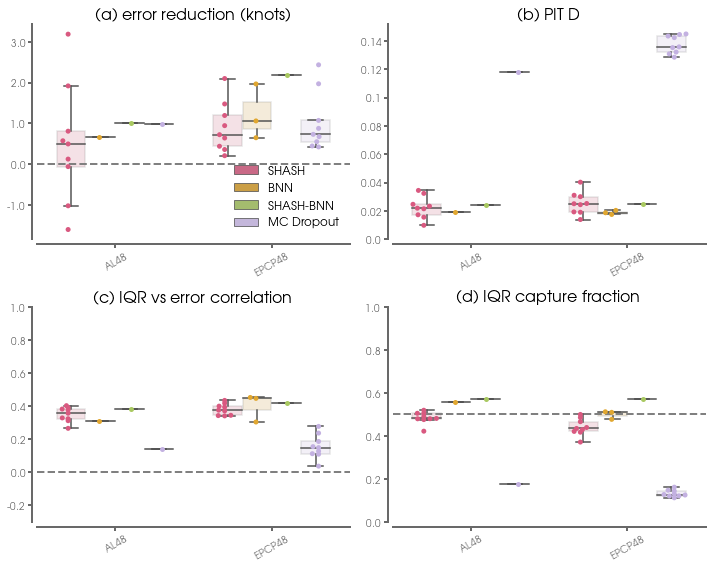

In [11]:
import seaborn as sns
colors = ('#D95980','#A9C961','#C3B1E1','#351F27')#('#284E60','#FFA83A','#D95980','#C3B1E1','#FFA83A')#colors = ('#284E60','#FFA83A','#D95980','#C3B1E1',)#('#284E60','#E1A730','#D95980','#C3B1E1','#351F27','#A9C961')
colors = ('#D95980','#E1A730','#A9C961','#C3B1E1','#351F27')
panel_letters = ('(a)','(b)','(c)','(d)')
x_axis_list = ("basin_lead",)#("basin_lead", "exp_name")

metric_data = ''
metric_list = ('median_error_reduction_test',
               'pit_D_valtest',
               'iqr_error_spearman_valtest',                                                                     
               'iqr_capture_valtest',
              )
title_text = ('(a) error reduction (knots)',
              '(b) PIT D',
              '(c) IQR vs error correlation',
              '(d) IQR capture fraction',
             )

for x_axis in x_axis_list:
    f, axs = plt.subplots(2, 2, figsize=(10,8))
    axs = axs.flatten()
    
    for imetric, metric in enumerate([m + metric_data for m in metric_list]):
        ax = axs[imetric]
        g1 = sns.boxplot(x=x_axis, 
                         y=metric, 
                         hue="uncertainty_type",
                         data=df_metrics,
                         palette=colors,
                         width=.75,
                         dodge=True,                    
                         boxprops={'alpha':.2,
                                   'edgecolor': 'gray',
                                  },
                         fliersize=0,
                         ax=ax)
        g2 = sns.swarmplot(x=x_axis, 
                           y=metric, 
                           hue="uncertainty_type",
                           palette=colors,
                           data=df_metrics, 
                           size=5,
                           dodge=True,
                           ax=ax)
        if imetric == 0:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[:4], ('SHASH','BNN','SHASH-BNN','MC Dropout'),fontsize=12,frameon=False)
            # ax.legend(handles[:3], ('SHASH','SHASH-BNN','SHASH-BNN-LastLayer'),fontsize=10,frameon=True,loc=4)                        
        else:
            ax.get_legend().remove()
        
        if(metric.find('iqr_capture') > -1):
            ax.axhline(y=0.5,linewidth=2,linestyle='--',color='gray')
            ax.set_ylim(0,1.0)
        if(metric.find('pit_D') > -1):
            ax.set_ylim(0,None)
        if(metric.find('reduction') > -1):
            ax.axhline(y=0.0,linewidth=2,linestyle='--',color='gray')
            # ax.set_ylim(-1.85,3.5)
        if(metric.find('reduction') == -1 and metric.find('n_error') > -1):
            ax.set_ylim(0.,22.)
        if(metric.find('iqr_error')> -1):
            ax.set_ylim(-.3,1.)
            ax.axhline(y=0.0,linewidth=2,linestyle='--',color='gray')        

        ax.set_title(title_text[imetric],
                     fontsize=FS,
                     color='k',
                    )
        
        # ax.get_legend().remove()
        x_tick_labels = ax.get_xticklabels()
        # ax.set_xticklabels([])
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        yticks = np.around(ax.get_yticks(),3)
        ax.set_yticklabels(yticks)       
        ax.set_ylabel('')
        
        format_spines(ax)
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        ax.set_xlabel('')
        
    plt.tight_layout()    
    plt.savefig(FIGURE_PATH + 'uq_comparisonsMetrics_leaveoneout' + APPEND_NAME + '.png', dpi=dpiFig)    
    plt.show()